# Lyric Mood Classification - Baselines

In this notebook, we establish baseline classification accuracies from several common classification strategies:
* Most-Common-Case
* Multinomial Naive-Bayes (NB)
* Support Vector Machines (SVM)

For each of the above, we baseline with several forms of input:
* Unequalized Moods
* Unequalized Mood Quadrants
* Equalized Moods
* Equalized Mood Quadrants
* Equalized Training Moods, Unequalized Test Moods
* Equalized Training Mood Quadrants, Unequalized Test Mood Quadrants

Where "unequalized" vs "equalized" refers to oversampling the under represented mood categories to create a more evenly distributed dataset and "quadrants" refers to grouping the categories into four quadrants to eliminate overlap between the moods.

We will use these baselines to compare to our CNN for mood classification.

In [69]:
# Project Imports
from label_lyrics import CSV_LABELED_LYRICS_EXPANDED
from mood_classification import build_lyrics_dataset, split_data, split_x_y, pad_data

# Python and Package Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import WordPunctTokenizer, word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [70]:
# Helpers
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

## Baselining Functions

Here we define functions for each classifier to be used in the following sections that vary based on form of data input.

In [71]:
def _most_common_case_accuracy(x, y):
    total_count = len(x)
    common_count = pd.Series(y).value_counts().max()
    accuracy = common_count / total_count
    return accuracy
    
def most_common_case_classification(df_train, df_dev, df_test):
    train_acc = _most_common_case_accuracy(df_train.lyrics_filename, df_train.mood) 
    dev_acc = _most_common_case_accuracy(df_dev.lyrics_filename, df_dev.mood)
    test_acc = _most_common_case_accuracy(df_test.lyrics_filename, df_test.mood)
    print('Most-Common-Case Classifier Train Accuracy:', pprint_accuracy(train_acc))
    print('Most-Common-Case Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    print('Most-Common-Case Classifier Test Accuracy:', pprint_accuracy(test_acc))


In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def _prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

def prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics):
    # convert lyrics to counts and term-frequencies
    count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = _prep_lyrics_for_nb(train_lyrics)
    #print(x_train_tfidf.shape)
    _, x_dev_counts, _, x_dev_tfidf = _prep_lyrics_for_nb(dev_lyrics, count_vect, tfidf_transformer)
    #print(x_dev_tfidf.shape)
    _, x_test_counts, _, x_test_tfidf = _prep_lyrics_for_nb(test_lyrics, count_vect, tfidf_transformer)
    #print(x_test_tfidf.shape)
    return x_train_tfidf, x_dev_tfidf, x_test_tfidf

def nb_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = MultinomialNB().fit(x_train_tfidf, y_train.astype('int')) 
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

In [73]:
def svm_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
                max_iter=5, tol=None).fit(x_train_tfidf, y_train.astype('int'))
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

In [75]:
def get_and_plot_x_y_data(quadrants, pad_data, pad_train_only=False):
    print('building dataset')
    df = build_lyrics_dataset(
        CSV_LABELED_LYRICS_EXPANDED,
        word_tokenize,
        quadrants=quadrants,
        pad_data_flag=pad_data and not pad_train_only)

    print('plotting moods')
    _ = df.mood.value_counts().plot(kind='bar', title='mood counts')

    print('splitting data')
    df_train, df_dev, df_test = split_data(df)
    
    if pad_data and pad_train_only:
        print('padding train data')
        df_train = pad_data(df_train)
    
    _ = df_train.mood.value_counts().plot(kind='bar', title='train data mood counts')
    _ = df_dev.mood.value_counts().plot(kind='bar', title='dev data mood counts')
    _ = df_test.mood.value_counts().plot(kind='bar', title='test data mood counts')

    x_train, y_train, x_dev, y_dev, x_test, y_test = split_x_y(
        df_train, df_dev, df_test, x_col='preprocessed_lyrics')

    print('***\nMost-Common-Case\n')
    most_common_case_classification(
        df_train,
        df_dev,
        df_test)
    print('***\nMultinomial Naive-Bayes\n')
    nb_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)
    print('***\nSupport Vector Machines\n')
    svm_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)


## Unequalized Moods


building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 40.07%
Most-Common-Case Classifier Dev Accuracy: 39.36%
Most-Common-Case Classifier Test Accuracy: 39.81%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 39.67%
Naive Bayes Classifier Test Accuracy: 39.93%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 45.41%
SVM Classifier Test Accuracy: 44.88%


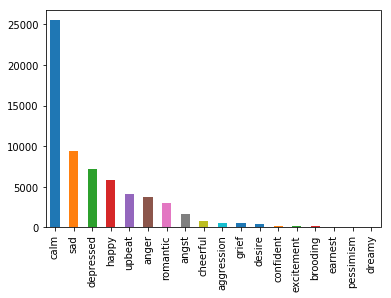

In [46]:
get_and_plot_x_y_data(quadrants=False, pad_data=False)

## Unequalized Moods Quadrants

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 42.87%
Most-Common-Case Classifier Dev Accuracy: 42.78%
Most-Common-Case Classifier Test Accuracy: 43.61%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 45.95%
Naive Bayes Classifier Test Accuracy: 46.78%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 51.29%
SVM Classifier Test Accuracy: 50.95%


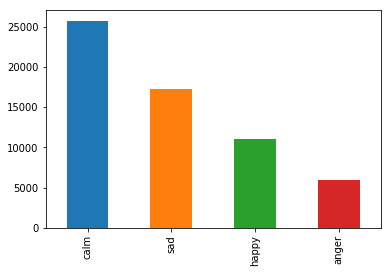

In [47]:
get_and_plot_x_y_data(quadrants=True, pad_data=False)

## Equalized Moods

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.59%
Most-Common-Case Classifier Dev Accuracy: 5.69%
Most-Common-Case Classifier Test Accuracy: 5.75%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 74.74%
Naive Bayes Classifier Test Accuracy: 74.63%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 67.35%
SVM Classifier Test Accuracy: 67.28%


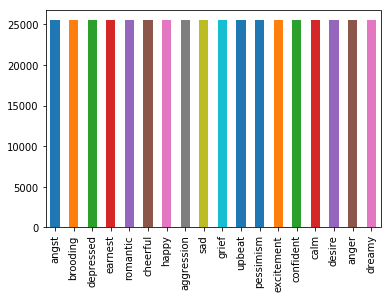

In [67]:
get_and_plot_x_y_data(quadrants=False, pad_data=True)

## Equalized Mood Quadrants

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 25.13%
Most-Common-Case Classifier Dev Accuracy: 25.34%
Most-Common-Case Classifier Test Accuracy: 25.34%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 55.32%
Naive Bayes Classifier Test Accuracy: 55.19%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 54.28%
SVM Classifier Test Accuracy: 54.07%


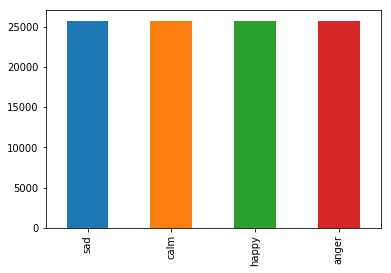

In [68]:
get_and_plot_x_y_data(quadrants=True, pad_data=True)

# Equalized Training Moods, Unequalized Test Moods

In [ ]:
get_and_plot_x_y_data(quadrants=False, pad_data=True, pad_train_only=True)

# Unequalized Training Mood Quadrants, Unequalized Test Mood Quadrants